# Exploratory Data Analysis and Tranformations
Barcelona Municipality Homes for Sale obtained throgh Idealista API on Oct and Nov 2024

In this Jupyter Notebook, the exploratory data analysis and transformations needed are done.
All these transformations are included in the sciript 'transform_data.py', that should be executed after extracting the api properties and loading to mongo db.

On the main_api_extract_prep.py script, all of the steps are performed from API extract to saving the trasformed data in the folder preprocessed_data.

In [1]:
import os 
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from idealista_api_extractor.extract_data import *
from idealista_api_extractor.config import *
from idealista_api_extractor.filters import * 
from mongodb_operations.insert_read_data import *
from mongodb_operations.config import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import warnings
from typing import List, Optional
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

warnings.filterwarnings("ignore")

from eda_methods import EdaMethods


## Dataset Loading

In [2]:
# read data from mongo db
mongo_handler = MongoDBHandler()  # Initialize MongoDB handler
mongo_data = mongo_handler.read_data() 

# create df
df = pd.json_normalize(mongo_data)
df.columns

Retrieved 16402 documents from MongoDB.


Index(['_id', 'propertyCode', 'thumbnail', 'externalReference', 'numPhotos',
       'price', 'propertyType', 'operation', 'size', 'rooms', 'bathrooms',
       'address', 'province', 'municipality', 'district', 'country',
       'neighborhood', 'latitude', 'longitude', 'showAddress', 'url',
       'distance', 'description', 'hasVideo', 'status', 'newDevelopment',
       'hasLift', 'priceByArea', 'hasPlan', 'has3DTour', 'has360',
       'hasStaging', 'topNewDevelopment', 'topPlus', 'priceInfo.price.amount',
       'priceInfo.price.currencySuffix',
       'priceInfo.price.priceDropInfo.formerPrice',
       'priceInfo.price.priceDropInfo.priceDropValue',
       'priceInfo.price.priceDropInfo.priceDropPercentage',
       'detailedType.typology', 'suggestedTexts.subtitle',
       'suggestedTexts.title', 'highlight.groupDescription', 'floor',
       'exterior', 'newDevelopmentFinished', 'parkingSpace.hasParkingSpace',
       'parkingSpace.isParkingSpaceIncludedInPrice',
       'detailedType.s

In [3]:
# Count number of columns
print('Number of variables:', len(df.columns))
# Count number rows
print('Number of records:', len(df.index))

Number of variables: 50
Number of records: 16402


### Filter provinces and municipalities

In [4]:
# check provinces
df['province'].value_counts()

province
Barcelona    13302
Girona        1619
Tarragona     1468
Lleida          13
Name: count, dtype: int64

In [5]:
bcn_df = df[df['municipality'] == 'Barcelona']

# unique property codes, much less than the 13302 that we showed before
len(bcn_df['propertyCode'].unique())

2922

In [6]:
# deleting duplicaes of property code
bcn_df = bcn_df.drop_duplicates(subset='propertyCode')

# count municipalities
bcn_df['municipality'].value_counts()

municipality
Barcelona    2922
Name: count, dtype: int64

In [7]:
bcn_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2922 entries, 0 to 16333
Data columns (total 50 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   _id                                                2922 non-null   object 
 1   propertyCode                                       2922 non-null   object 
 2   thumbnail                                          2914 non-null   object 
 3   externalReference                                  2609 non-null   object 
 4   numPhotos                                          2922 non-null   int64  
 5   price                                              2922 non-null   float64
 6   propertyType                                       2922 non-null   object 
 7   operation                                          2922 non-null   object 
 8   size                                               2922 non-null   float64
 9   rooms       

### Adding dataset idealista price m2

In [8]:
district_prices = pd.read_csv('idealista_pricem2_district.csv')
            
district_prices

,district,price_m2_oct24,monthly_var,quart_var,annual_var,price_m2_historical_max,var_from_max
0,Sarrià-Sant Gervasi,5900,0.015,0.010,0.059,5900,0.000
1,Les Corts,5724,0.018,0.036,0.137,5724,0.000
2,Eixample,5674,0.003,0.026,0.122,5674,0.000
3,Gràcia,4973,0.002,0.002,0.088,4973,0.000
4,Ciutat Vella,4571,0.018,0.036,0.061,4600,-0.006
5,Sant Martí,4321,0.037,0.036,0.141,4321,0.000
6,Sants-Montjuïc,3882,0.011,0.040,0.094,3929,-0.012
7,Sant Andreu,3536,0.020,0.049,0.128,3536,0.000
8,Horta Guinardó,3442,0.014,0.035,0.072,3442,0.000
9,Nou Barris,2466,0.002,0.029,0.026,2941,-0.162


In [9]:
bcn_df = bcn_df.merge(district_prices, on='district', how='left')
bcn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 56 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   _id                                                2922 non-null   object 
 1   propertyCode                                       2922 non-null   object 
 2   thumbnail                                          2914 non-null   object 
 3   externalReference                                  2609 non-null   object 
 4   numPhotos                                          2922 non-null   int64  
 5   price                                              2922 non-null   float64
 6   propertyType                                       2922 non-null   object 
 7   operation                                          2922 non-null   object 
 8   size                                               2922 non-null   float64
 9   rooms   

## Exploratory Analysis & Transformations

### Price

The price variable was adjusted to include the parking price where it was not already incorporated.
Both the histogram and QQ-plot display a roughly symmetric shape with a slight peak in the middle and no extreme skewness.
Several outliers, primarily in the higher quantiles, were identified and removed.

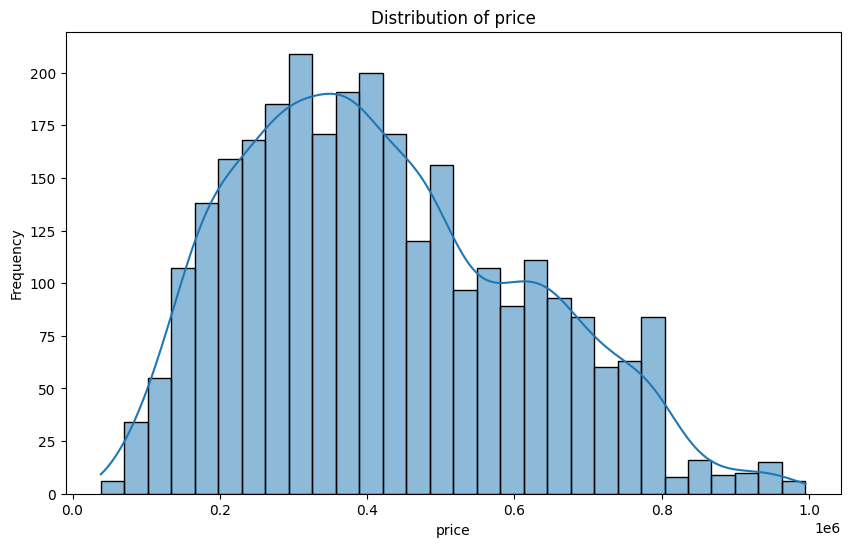

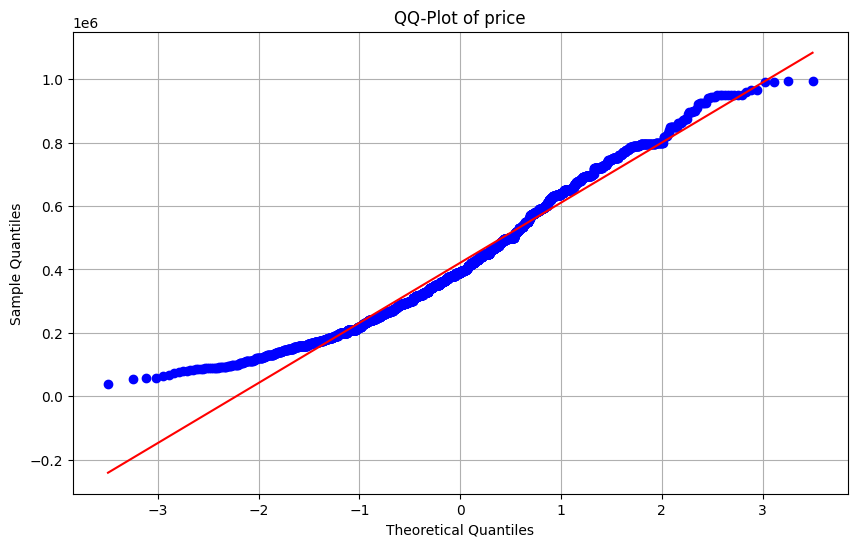

In [10]:
# Plot distibution for price

eda_methods = EdaMethods(bcn_df)
eda_methods.plot_distribution('price')

#### Sum parking space price to price

In [11]:
bcn_df[['parkingSpace.parkingSpacePrice', 'parkingSpace.isParkingSpaceIncludedInPrice', 'parkingSpace.hasParkingSpace' ]].value_counts()

parkingSpace.parkingSpacePrice  parkingSpace.isParkingSpaceIncludedInPrice  parkingSpace.hasParkingSpace
20000.0                         False                                       True                            26
30000.0                         False                                       True                            17
25000.0                         False                                       True                            14
35000.0                         False                                       True                            10
40000.0                         False                                       True                             5
15000.0                         False                                       True                             5
24000.0                         False                                       True                             4
150.0                           False                                       True                             3
1.0    

In [12]:
bcn_df['parkingSpace.isParkingSpaceIncludedInPrice'].value_counts()

parkingSpace.isParkingSpaceIncludedInPrice
True     185
False    107
Name: count, dtype: int64

In [13]:
bcn_df[['parkingSpace.parkingSpacePrice', 'parkingSpace.isParkingSpaceIncludedInPrice', 'parkingSpace.hasParkingSpace' ]][bcn_df['parkingSpace.isParkingSpaceIncludedInPrice'] == True]

,parkingSpace.parkingSpacePrice,parkingSpace.isParkingSpaceIncludedInPrice,parkingSpace.hasParkingSpace
52,NaN,True,True
62,NaN,True,True
98,NaN,True,True
147,NaN,True,True
153,NaN,True,True
...,...,...,...
2853,NaN,True,True
2867,NaN,True,True
2898,NaN,True,True
2899,NaN,True,True


In [14]:
bcn_df['parkingSpace.parkingSpacePrice'].value_counts()
bcn_df['price'] = bcn_df['parkingSpace.parkingSpacePrice'].fillna(0).astype(int) + bcn_df['price'].astype(int)

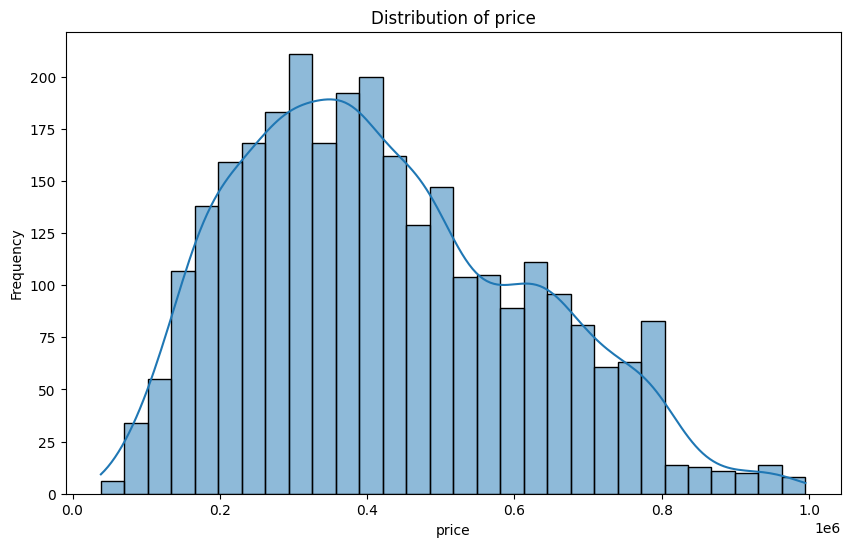

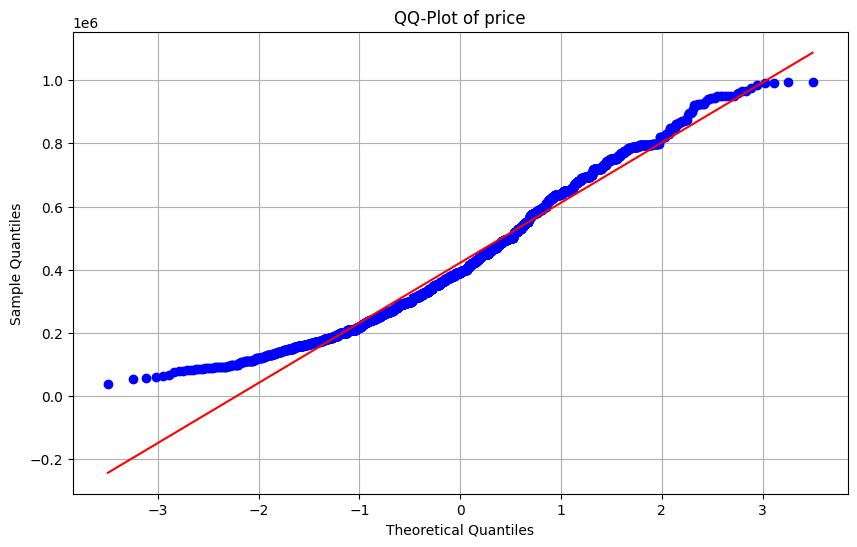

In [15]:
eda_methods = EdaMethods(bcn_df)
eda_methods.plot_distribution('price')

In [16]:
from scipy.stats import shapiro

stat, p = shapiro(bcn_df['price'].dropna())
print(f"Statistic: {stat}, p-value: {p}")
if p > 0.05:
    print("Follows normal distribution")
else:
    print("Does not follow a normal distribution")

Statistic: 0.9711321707345509, p-value: 7.920053315605785e-24
Does not follow a normal distribution


In [17]:
print(bcn_df['price'].skew())

0.48118347778744835


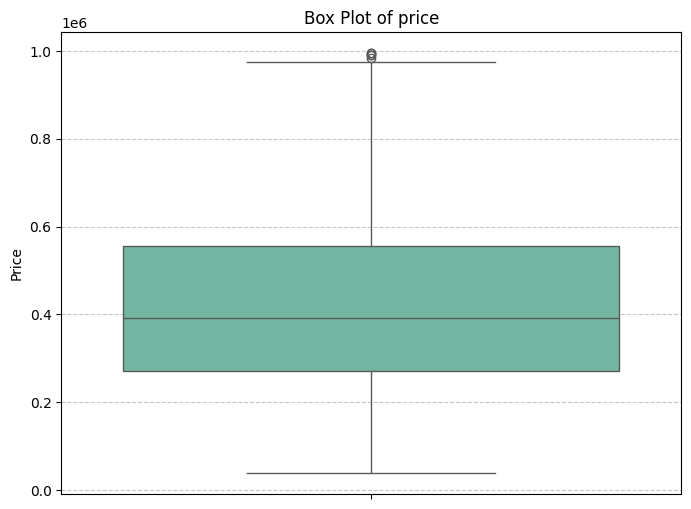

In [18]:
eda_methods.plot_boxplot('price')

In [19]:
Q1 = bcn_df['price'].quantile(0.25) 
Q3 = bcn_df['price'].quantile(0.75) 
IQR = Q3 - Q1 
lower_bound = Q1 - 1.5 * IQR 
upper_bound = Q3 + 1.5 * IQR 
bcn_df = bcn_df[(bcn_df['price'] >= lower_bound) & (bcn_df['price'] <= upper_bound)]

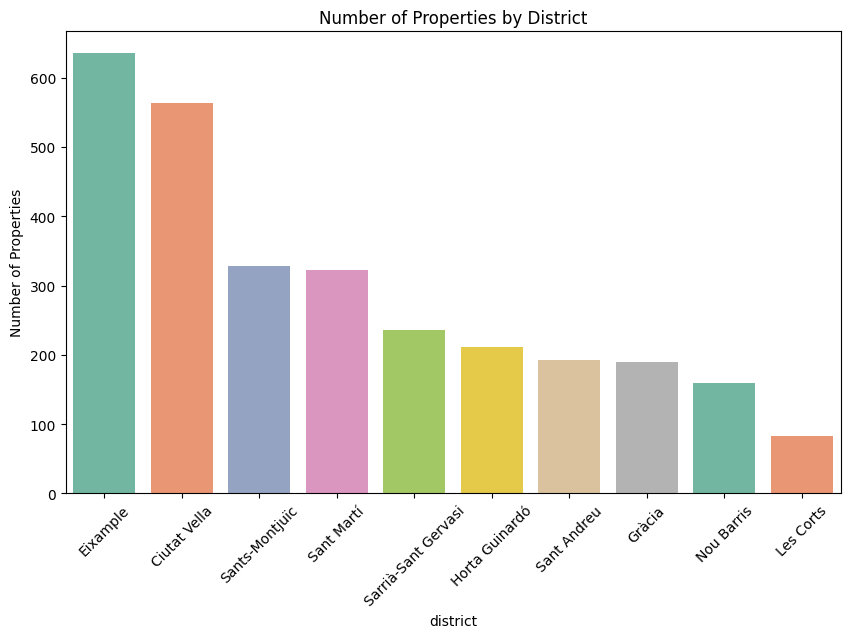

In [20]:
# Graph of district count
eda_methods.plot_counts('district')

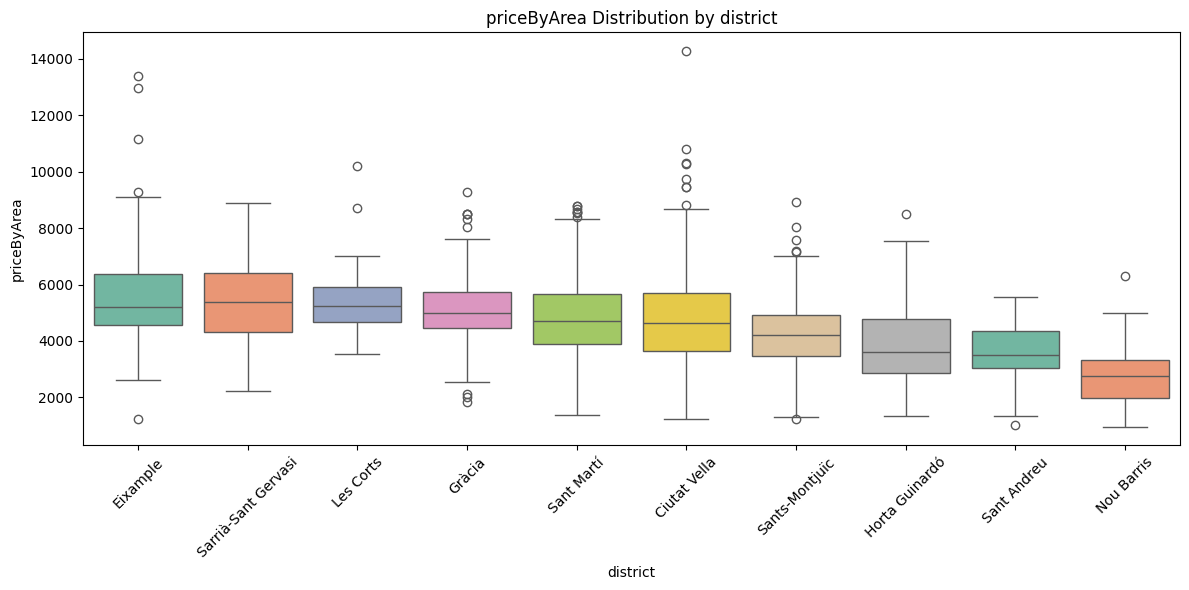

In [21]:
eda_methods.plot_boxplot_for_categories('district', 'priceByArea')

In [22]:
bcn_df[['priceByArea', 'price_m2_oct24',
    'monthly_var',
    'quart_var',
    'annual_var',
    'price_m2_historical_max',
    'var_from_max' ]].corr()

,priceByArea,price_m2_oct24,monthly_var,quart_var,annual_var,price_m2_historical_max,var_from_max
priceByArea,1.000000,0.473928,-0.058690,-0.247993,0.196304,0.466942,0.312470
price_m2_oct24,0.473928,1.000000,-0.212613,-0.553296,0.316762,0.995343,0.571850
monthly_var,-0.058690,-0.212613,1.000000,0.455499,0.260086,-0.257853,0.270528
quart_var,-0.247993,-0.553296,0.455499,1.000000,0.207245,-0.584567,-0.016931
annual_var,0.196304,0.316762,0.260086,0.207245,1.000000,0.273139,0.519145
price_m2_historical_max,0.466942,0.995343,-0.257853,-0.584567,0.273139,1.000000,0.490246
var_from_max,0.312470,0.571850,0.270528,-0.016931,0.519145,0.490246,1.000000


In [23]:
# Example DataFrame (replace with your actual dataset)
# bcn_df = pd.read_csv("your_data.csv")  # Load your dataset here

# Calculate share of properties
total_properties = bcn_df['district'].count()
table_data = bcn_df.groupby('district').agg(
    Count_Properties=('price', 'size'),
    Avg_PriceByArea=('priceByArea', 'mean'),
    Avg_Price_m2_Oct24=('price_m2_oct24', 'mean'),
    Avg_Price_m2_Historical_Max=('price_m2_historical_max', 'mean')
).reset_index()

# Calculate share of properties and differences
table_data['Share_of_Properties (%)'] = (table_data['Count_Properties'] / total_properties) 
table_data['Diff_PriceByArea_Oct24'] = table_data['Avg_PriceByArea'] / table_data['Avg_Price_m2_Oct24'] -1
table_data['Diff_PriceByArea_Historical_Max'] = table_data['Avg_PriceByArea'] / table_data['Avg_Price_m2_Historical_Max'] -1

# Rename columns for better display
table_data.rename(columns={
    'district': 'District',
    'Avg_PriceByArea': 'Avg Price By Area (€)',
    'Avg_Price_m2_Oct24': 'Avg Price m² Oct24 (€)',
    'Avg_Price_m2_Historical_Max': 'Avg Price m² Historical Max (€)'
}, inplace=True)

# Order by Share of Properties
table_data.sort_values(by='Share_of_Properties (%)', ascending=False, inplace=True)

# Display the table
table_data

,District,Count_Properties,Avg Price By Area (€),Avg Price m² Oct24 (€),Avg Price m² Historical Max (€),Share_of_Properties (%),Diff_PriceByArea_Oct24,Diff_PriceByArea_Historical_Max
1,Eixample,633,5519.113744,5674.0,5674.0,0.217004,-0.027298,-0.027298
0,Ciutat Vella,563,4697.532860,4571.0,4600.0,0.193007,0.027682,0.021203
8,Sants-Montjuïc,328,4241.795732,3882.0,3929.0,0.112444,0.092683,0.079612
7,Sant Martí,321,4776.604361,4321.0,4321.0,0.110045,0.105440,0.105440
9,Sarrià-Sant Gervasi,234,5396.884615,5900.0,5900.0,0.080219,-0.085274,-0.085274
3,Horta Guinardó,212,3803.136792,3442.0,3442.0,0.072677,0.104921,0.104921
6,Sant Andreu,193,3636.564767,3536.0,3536.0,0.066164,0.028440,0.028440
2,Gràcia,190,5098.210526,4973.0,4973.0,0.065135,0.025178,0.025178
5,Nou Barris,160,2771.725000,2466.0,2941.0,0.054851,0.123976,-0.057557
4,Les Corts,83,5325.927711,5724.0,5724.0,0.028454,-0.069544,-0.069544


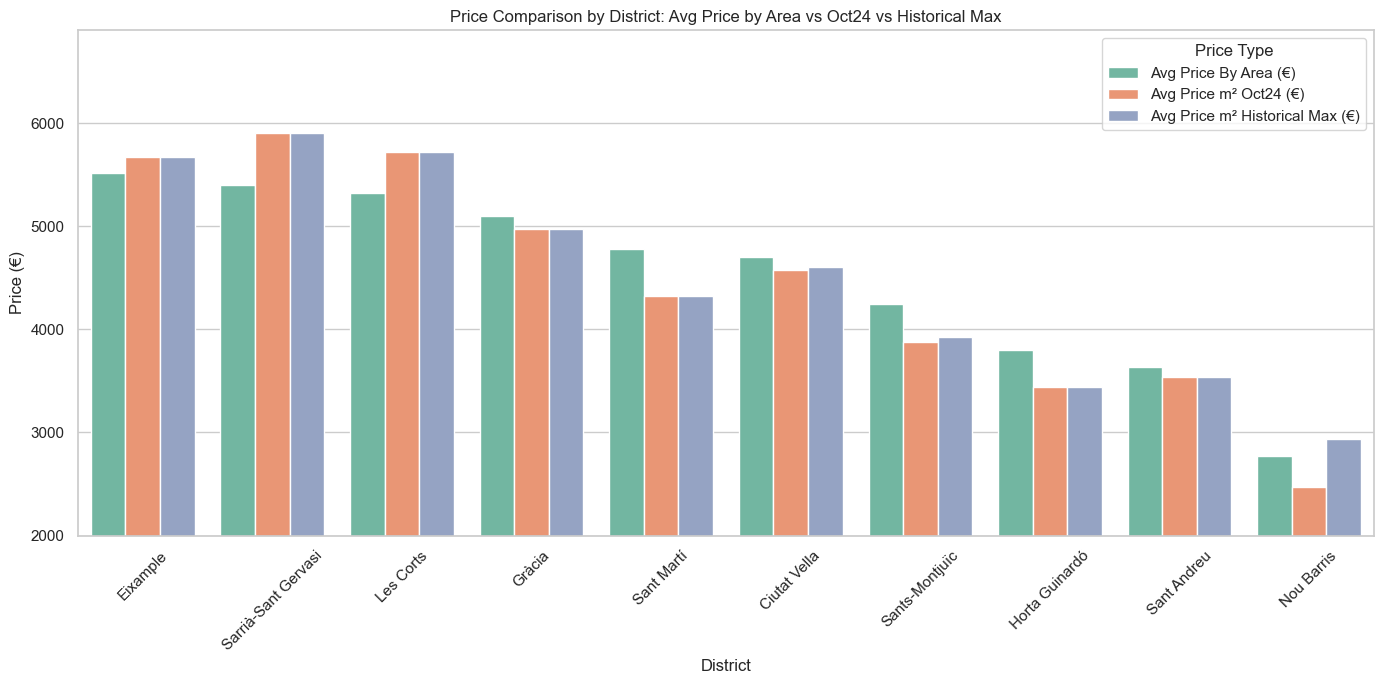

In [24]:
# Prepare the data for plotting
plot_data = table_data[['District', 'Avg Price By Area (€)', 'Avg Price m² Oct24 (€)', 'Avg Price m² Historical Max (€)']]

# Melt the data for easier plotting
plot_data_melted = plot_data.melt(id_vars='District', 
                                  value_vars=['Avg Price By Area (€)', 'Avg Price m² Oct24 (€)', 'Avg Price m² Historical Max (€)'], 
                                  var_name='Price_Type', 
                                  value_name='Price (€)')

# Order the data by 'Avg Price By Area (€)' for sorting
district_order = plot_data.sort_values('Avg Price By Area (€)', ascending=False)['District']

# Set the Seaborn style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(14, 7))
sns.barplot(x='District', y='Price (€)', hue='Price_Type', data=plot_data_melted, palette="Set2", order=district_order)

# Customize the plot
plt.title('Price Comparison by District: Avg Price by Area vs Oct24 vs Historical Max')
plt.xlabel('District')
plt.ylabel('Price (€)')
plt.xticks(rotation=45)
plt.legend(title='Price Type')

# Set the y-axis to start from 2000
plt.ylim(2000, plot_data_melted['Price (€)'].max() + 1000)

# Show the plot
plt.tight_layout()
plt.show()


In [25]:
plot_data[['Avg Price By Area (€)', 'Avg Price m² Oct24 (€)', 'Avg Price m² Historical Max (€)']].corr()

,Avg Price By Area (€),Avg Price m² Oct24 (€),Avg Price m² Historical Max (€)
Avg Price By Area (€),1.000000,0.974590,0.957154
Avg Price m² Oct24 (€),0.974590,1.000000,0.994011
Avg Price m² Historical Max (€),0.957154,0.994011,1.000000


### Size, rooms, bathrooms

A similar analysis was performed for the size variable, yielding results comparable to those for
price. A normal distribution was observed, and the box plot revealed the presence of outliers, that were removed.

The rooms and bathrooms variables were also analyzed. Although outliers were detected, they were not removed due to the large sample size (over 200 samples) being affected.

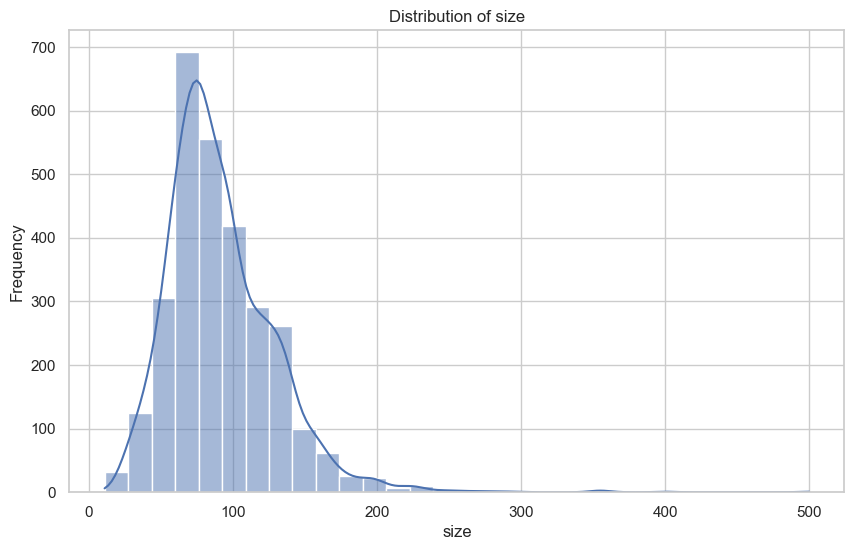

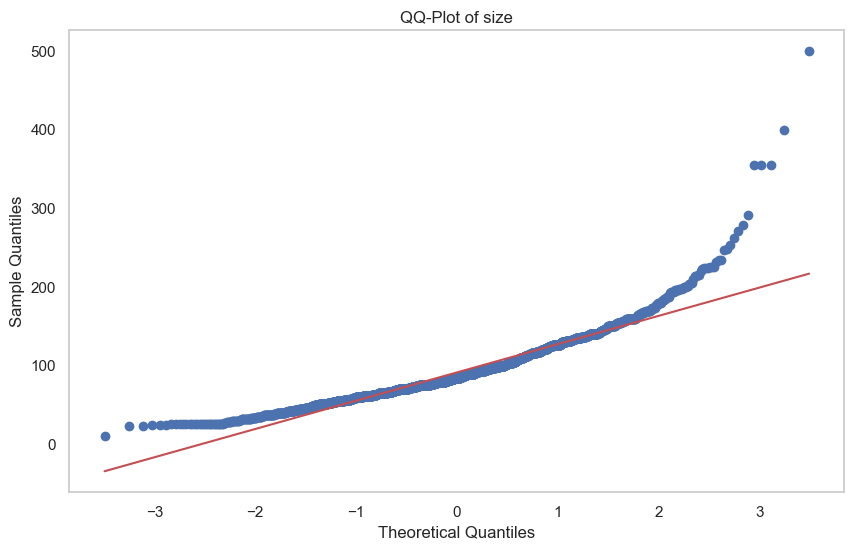

In [26]:
eda_methods = EdaMethods(bcn_df)
eda_methods.plot_distribution('size')

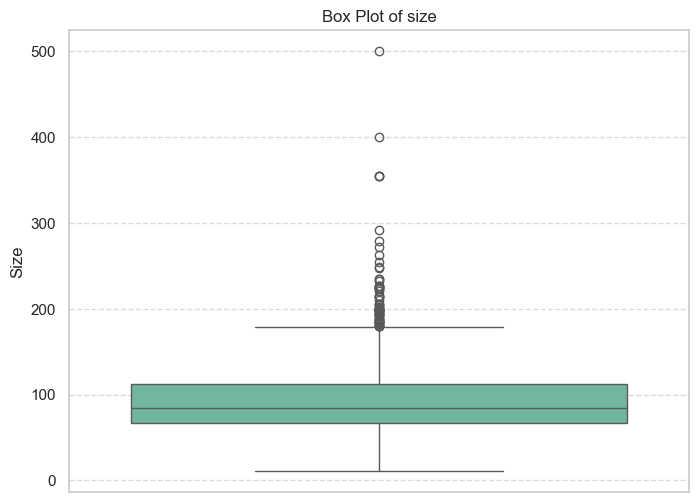

In [27]:
# Box plot
eda_methods.plot_boxplot('size')

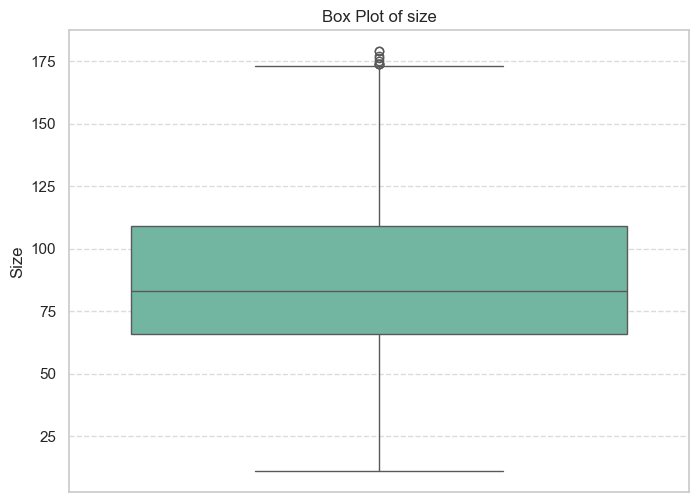

In [28]:
Q1 = bcn_df['size'].quantile(0.25) 
Q3 = bcn_df['size'].quantile(0.75) 
IQR = Q3 - Q1 
lower_bound = Q1 - 1.5 * IQR 
upper_bound = Q3 + 1.5 * IQR 
bcn_df = bcn_df[(bcn_df['size'] >= lower_bound) & (bcn_df['size'] <= upper_bound)]
eda_methods = EdaMethods(bcn_df)
eda_methods.plot_boxplot('size')

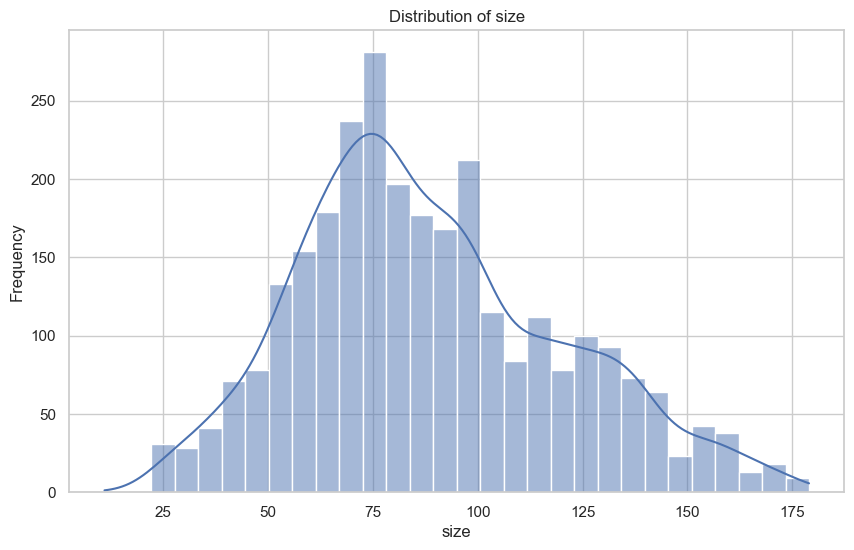

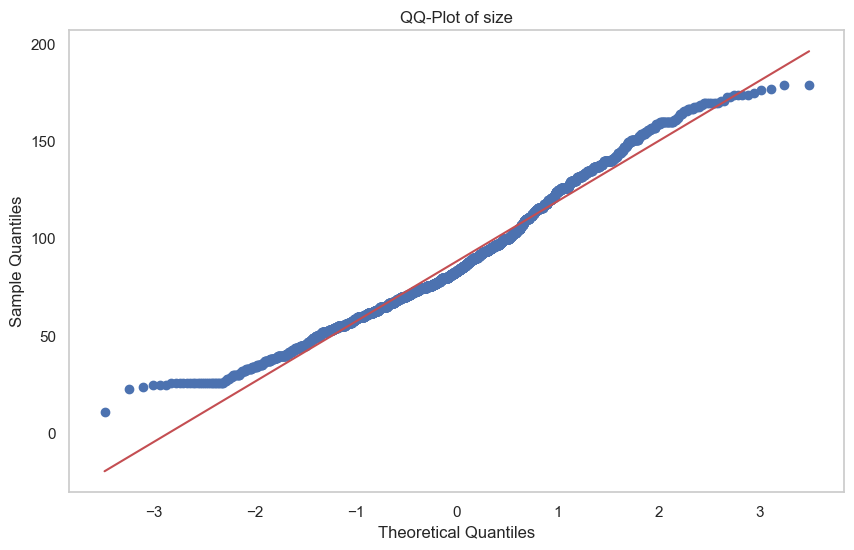

In [29]:
eda_methods.plot_distribution('size')

In [30]:
stat, p = shapiro(bcn_df['size'].dropna())
print(f"Statistic: {stat}, p-value: {p}")
if p > 0.05:
    print("Follows normal distribution")
else:
    print("Does not follow a normal distribution")

Statistic: 0.9781058523477272, p-value: 1.5247948746932047e-20
Does not follow a normal distribution


In [31]:
print(bcn_df['size'].skew())

0.46473514899646484


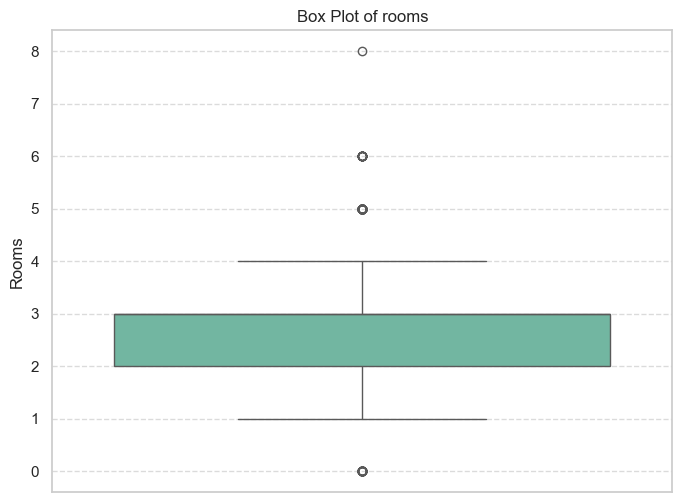

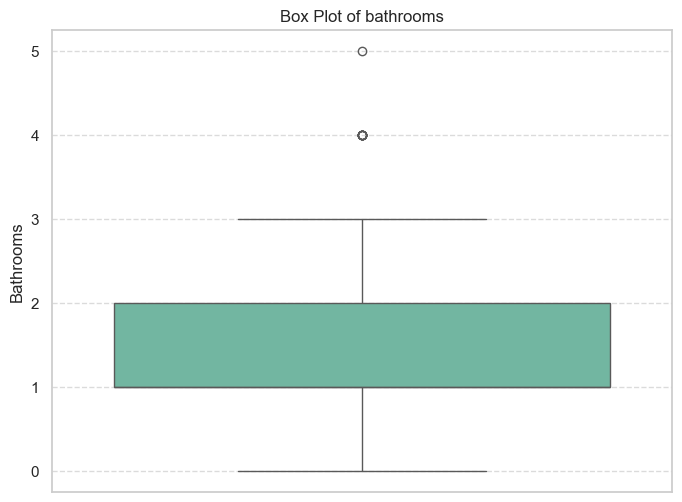

In [32]:
eda_methods.plot_boxplot('rooms')
eda_methods.plot_boxplot('bathrooms')

In [33]:
bcn_df

# even thou outliers are detected they wont be delete it beacouse around 300 samples will be delete it and is too much

,_id,propertyCode,thumbnail,externalReference,numPhotos,price,propertyType,operation,size,rooms,...,parkingSpace.hasParkingSpace,parkingSpace.isParkingSpaceIncludedInPrice,detailedType.subTypology,parkingSpace.parkingSpacePrice,price_m2_oct24,monthly_var,quart_var,annual_var,price_m2_historical_max,var_from_max
0,671295cae6b2727f6e10a9e4,105376770,https://img4.idealista.com/blur/WEB_LISTING/0/...,CL-02064-0001,22,249000,flat,sale,55.0,2,...,NaN,NaN,NaN,NaN,3882,0.011,0.040,0.094,3929,-0.012
1,6713f8f71b881c2efa4da1b6,105534264,https://img4.idealista.com/blur/WEB_LISTING/0/...,BCN010589717,40,749000,flat,sale,118.0,2,...,NaN,NaN,NaN,NaN,5900,0.015,0.010,0.059,5900,0.000
2,6713f9577bb1f03732f1711a,105989074,https://img4.idealista.com/blur/WEB_LISTING/0/...,SR290437,39,330000,flat,sale,69.0,2,...,NaN,NaN,NaN,NaN,4973,0.002,0.002,0.088,4973,0.000
3,6713f9577bb1f03732f1711b,105524784,https://img4.idealista.com/blur/WEB_LISTING/0/...,18118,32,749000,flat,sale,118.0,2,...,NaN,NaN,NaN,NaN,5900,0.015,0.010,0.059,5900,0.000
4,6713f9577bb1f03732f1711c,105280335,https://img4.idealista.com/blur/WEB_LISTING/0/...,ROCAF.479K.21.06,26,479000,flat,sale,105.0,4,...,NaN,NaN,NaN,NaN,5674,0.003,0.026,0.122,5674,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,672ba96781ac9828824f247d,106376387,https://img4.idealista.com/blur/WEB_LISTING/0/...,AP-RES-1638-139,18,315000,flat,sale,62.0,2,...,NaN,NaN,NaN,NaN,3536,0.020,0.049,0.128,3536,0.000
2918,672ba96781ac9828824f2496,105511598,https://img4.idealista.com/blur/WEB_LISTING/0/...,AP0007-3292,24,198000,flat,sale,40.0,1,...,NaN,NaN,NaN,NaN,4571,0.018,0.036,0.061,4600,-0.006
2919,672ba96781ac9828824f249e,104974632,https://img4.idealista.com/blur/WEB_LISTING/0/...,671,28,472000,flat,sale,85.0,1,...,True,False,NaN,22000.0,4321,0.037,0.036,0.141,4321,0.000
2920,672ba96781ac9828824f24a2,105368446,https://img4.idealista.com/blur/WEB_LISTING/0/...,705,26,475000,flat,sale,78.0,2,...,NaN,NaN,NaN,NaN,4571,0.018,0.036,0.061,4600,-0.006


### Other numercal variables

Two additional numerical variables were analyzed: the number of photos included in the listing and the distance to the city center. The number of photos exhibits several outliers, ranging from 40 to a maximum of 100 photos per listing, whereas the distance variable exhibits only a limited number of outliers; but outliers will not be removed; since these variables are not that important.

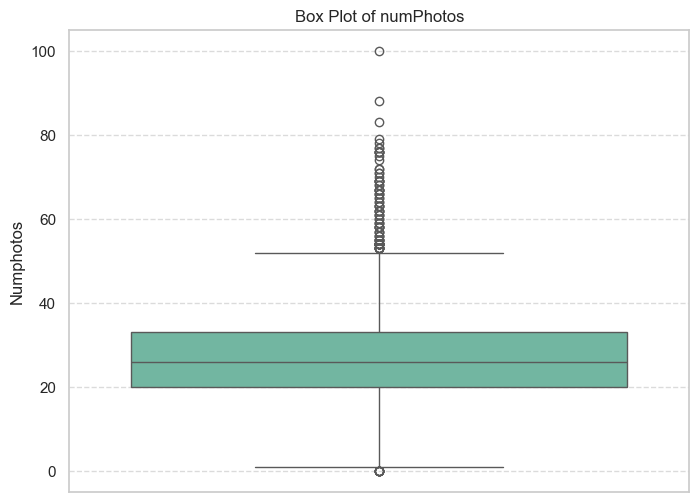

In [34]:
eda_methods.plot_boxplot('numPhotos')

In [35]:
bcn_df['distance'] = bcn_df['distance'].astype(int)
bcn_df.describe()

,numPhotos,price,size,rooms,bathrooms,latitude,longitude,distance,priceByArea,priceInfo.price.amount,priceInfo.price.priceDropInfo.formerPrice,priceInfo.price.priceDropInfo.priceDropValue,priceInfo.price.priceDropInfo.priceDropPercentage,parkingSpace.parkingSpacePrice,price_m2_oct24,monthly_var,quart_var,annual_var,price_m2_historical_max,var_from_max
count,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,1.694000e+03,1694.000000,1694.000000,104.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000
mean,27.294386,414297.368070,88.499228,2.611579,1.487018,41.398328,2.166613,2818.864211,4724.147719,413373.883158,4.146497e+05,19395.391381,4.871311,25307.038462,4607.094035,0.013697,0.030431,0.094098,4644.296842,-0.011469
std,12.199753,187244.405717,31.267853,1.053337,0.595414,0.021247,0.021044,1787.711829,1546.485651,186359.861153,2.003219e+05,16892.513256,3.469379,10881.980541,956.024027,0.010461,0.011615,0.033794,897.276564,0.036581
min,0.000000,38500.000000,11.000000,0.000000,0.000000,41.352125,2.087458,46.000000,963.000000,38500.000000,5.770000e+04,2000.000000,1.000000,1.000000,2466.000000,0.002000,0.002000,0.026000,2941.000000,-0.162000
25%,20.000000,269000.000000,66.000000,2.000000,1.000000,41.380806,2.153517,1341.750000,3713.000000,269000.000000,2.550000e+05,10000.000000,3.000000,20000.000000,3882.000000,0.003000,0.026000,0.061000,3929.000000,-0.006000
50%,26.000000,390000.000000,83.000000,3.000000,1.000000,41.395071,2.168042,2604.500000,4701.000000,390000.000000,3.800000e+05,15000.000000,4.000000,25000.000000,4571.000000,0.014000,0.036000,0.094000,4600.000000,0.000000
75%,33.000000,540000.000000,109.000000,3.000000,2.000000,41.411039,2.179751,3966.000000,5617.750000,539000.000000,5.500000e+05,25000.000000,6.000000,30000.000000,5674.000000,0.018000,0.036000,0.122000,5674.000000,0.000000
max,100.000000,975000.000000,179.000000,8.000000,5.000000,41.463594,2.221541,8737.000000,14273.000000,965000.000000,1.100000e+06,220000.000000,43.000000,60000.000000,5900.000000,0.037000,0.049000,0.141000,5900.000000,0.000000


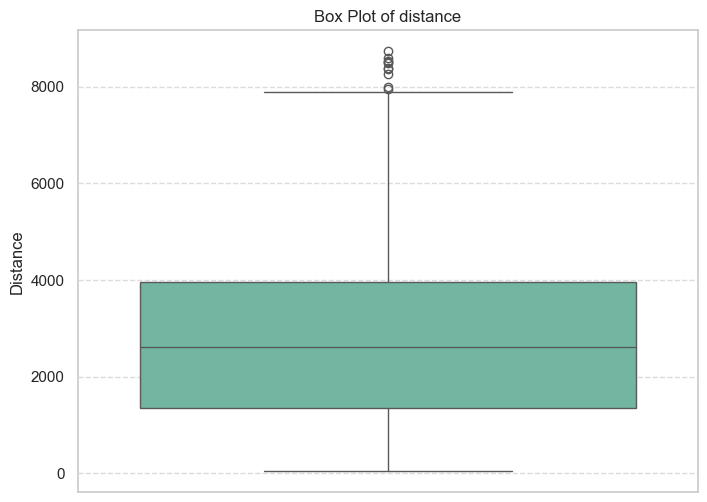

In [36]:
eda_methods.plot_boxplot('distance')

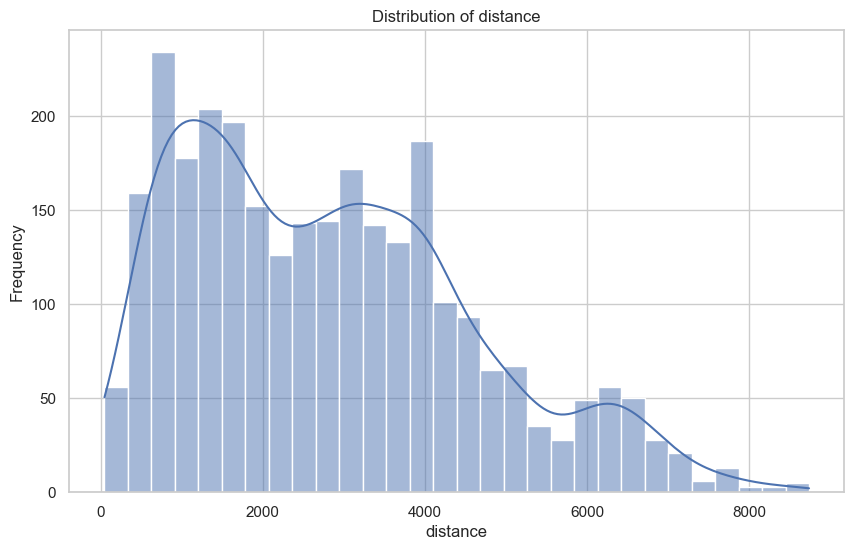

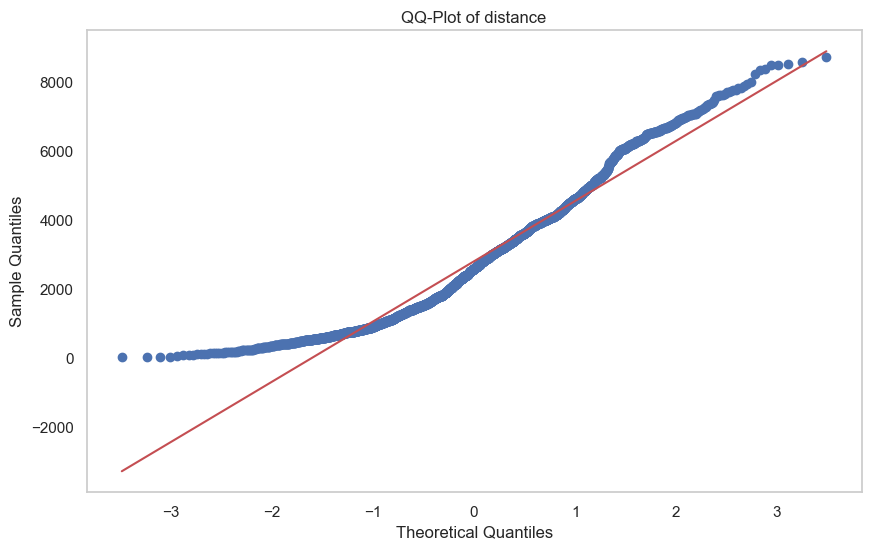

In [37]:
eda_methods.plot_distribution('distance')

### Floor

Properties situated above the 7th floor represent only 5% of the dataset. These properties will be reassigned to the 7th floor. Additionally, properties located in basement and semi-basement levels will be assigned a value of -2, mezzanine properties will be mapped to -1, and ground floor properties will be mapped to 0. Null values, typically representing properties such as chalets or country houses, will be assigned a value of 8, reflecting their higher price. The remaining null values will be replaced by the median value, which is 2.

In [38]:
floor_counts = bcn_df['floor'].value_counts()
floor_counts

floor
1     671
2     453
3     328
bj    321
4     268
en    173
5     141
6     101
7      66
8      59
9      20
st     10
-1      7
10      7
ss      6
17      3
15      3
13      2
11      2
16      2
18      2
14      1
12      1
-2      1
Name: count, dtype: int64

In [39]:
bcn_df['floor'].unique()

array([nan, '3', '1', '4', '2', 'en', '5', '9', 'bj', '17', '7', '6', '8',
       'ss', '15', '14', '10', '11', 'st', '-1', '16', '13', '18', '12',
       '-2'], dtype=object)

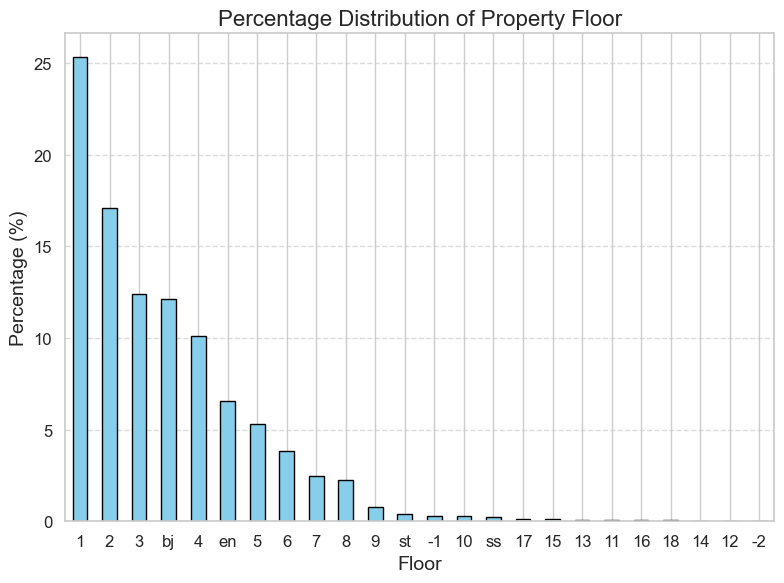

In [40]:
floor_counts = bcn_df['floor'].value_counts()
floor_percentages = (floor_counts / bcn_df['floor'].count()) * 100

plt.figure(figsize=(8, 6))
floor_percentages.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Percentage Distribution of Property Floor', fontsize=16)
plt.xlabel('Floor', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

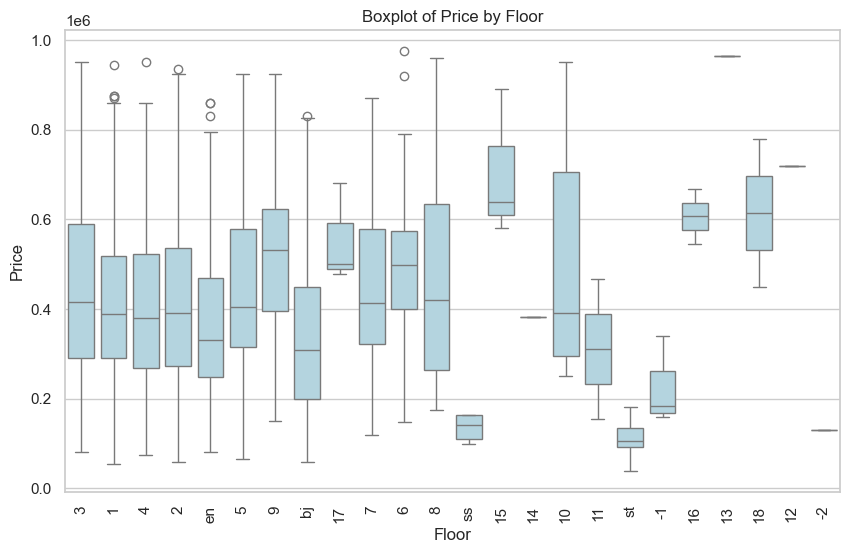

In [41]:
# Plotting the boxplot for 'floor' by 'price'
plt.figure(figsize=(10, 6))
sns.boxplot(x=bcn_df['floor'], y=bcn_df['price'], color='lightblue')
plt.title('Boxplot of Price by Floor')
plt.xlabel('Floor')
plt.ylabel('Price')
plt.xticks(rotation=90)  
plt.show()

In [42]:
floor_mapping = {
        'en': 0,  # Entresuelo
        'bj': -1,    # Bajo
        'st': -2, # Semi-sótano
        'ss': -2,   # Sótano
    }
    
        # Map non-numeric floor values
bcn_df['floor'] = bcn_df['floor'].map(floor_mapping).fillna(bcn_df['floor'])
        
        
        # Convert to numeric and handle errors 
        # fill nan with -3 that is a new number (8%)
bcn_df['floor'] = pd.to_numeric(bcn_df['floor'], errors='coerce')

bcn_df['floor'] = bcn_df['floor'].apply(
            lambda x: 7 if x >= 7 else x)

bcn_df['floor'].value_counts() 

floor
 1.0    671
 2.0    453
 3.0    328
-1.0    328
 4.0    268
 0.0    173
 7.0    168
 5.0    141
 6.0    101
-2.0     17
Name: count, dtype: int64

In [43]:
median_floor = bcn_df['floor'].median()
median_floor 

np.float64(2.0)

In [44]:
bcn_df['floor'] = bcn_df.apply(
    lambda row: 8 if row['propertyType'] in ['chalet', 'countryHouse'] 
    else median_floor if pd.isnull(row['floor']) 
    else row['floor'], axis=1
)
        

bcn_df['floor'].value_counts() 

floor
 1.0    671
 2.0    609
 3.0    328
-1.0    328
 4.0    268
 0.0    173
 7.0    168
 5.0    141
 6.0    101
 8.0     46
-2.0     17
Name: count, dtype: int64

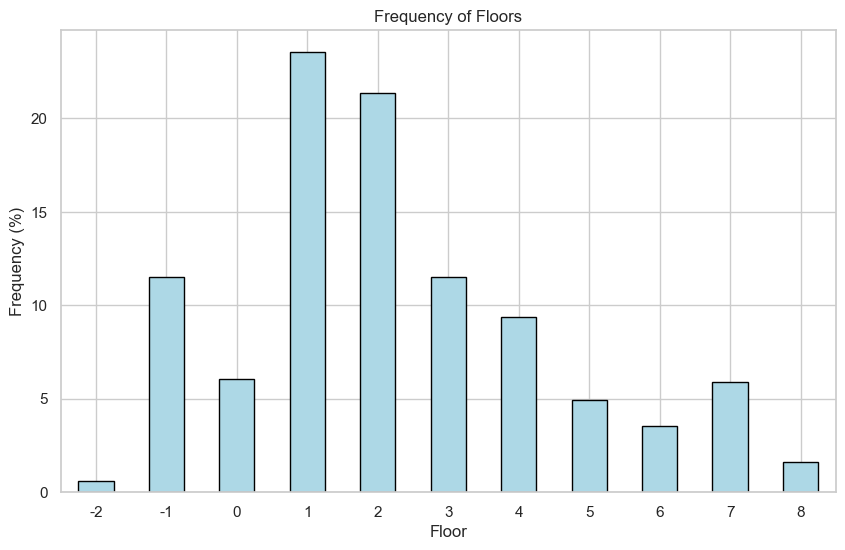

In [45]:
# Convert 'floor' to numeric (if it's not already) and handle any errors (e.g., non-numeric values)
bcn_df['floor'] = pd.to_numeric(bcn_df['floor'], errors='coerce')

# Get the value counts of 'floor', sorted by floor number, and normalize to percentage
floor_counts = bcn_df['floor'].value_counts(normalize=True).sort_index() * 100

# Plot the bar graph
plt.figure(figsize=(10, 6))
floor_counts.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Frequency of Floors')  # Title reflects the percentage
plt.xlabel('Floor')
plt.ylabel('Frequency (%)')
plt.xticks(rotation=0)  # Keep the x-axis labels horizontal
plt.xticks(ticks=range(len(floor_counts)), labels=floor_counts.index.astype(int))  # Remove decimals from x labels
plt.show()


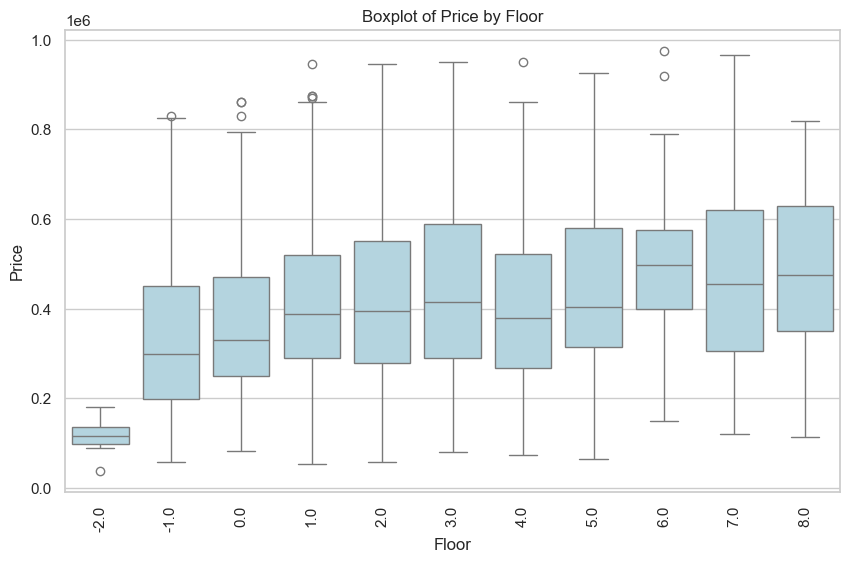

In [46]:
# Ensure 'floor' is numeric and handle any errors (e.g., non-numeric values)
bcn_df['floor'] = pd.to_numeric(bcn_df['floor'], errors='coerce')

# Plotting the boxplot for 'floor' by 'price'
plt.figure(figsize=(10, 6))
sns.boxplot(x=bcn_df['floor'], y=bcn_df['price'], color='lightblue')
plt.title('Boxplot of Price by Floor')
plt.xlabel('Floor')
plt.ylabel('Price')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()


### Status

Ordinal encoded

In [47]:
status_counts = bcn_df['status'].value_counts()
status_percentages = (status_counts / bcn_df['status'].count()) * 100
status_percentages

status
good              87.614356
renew             10.696692
newdevelopment     1.688951
Name: count, dtype: float64

In [48]:
status_mapping = {
            'good': 1,
            'renew': 2,
            'newdevelopment': 3,
        }
bcn_df['status'] = bcn_df['status'].map(status_mapping).fillna(0).astype(int)

### Property Type


Ordinal encoded

In [49]:
propertyType_counts = bcn_df['propertyType'].value_counts()
propertyType_percentages = (propertyType_counts / bcn_df['propertyType'].count()) * 100
propertyType_percentages

propertyType
flat            86.421053
penthouse        7.438596
duplex           3.438596
chalet           1.578947
studio           1.087719
countryHouse     0.035088
Name: count, dtype: float64

In [50]:
prop_mapping = {
            'studio': 0,
            'flat': 1,
            'penthouse': 2,
            'duplex': 2,
            'chalet': 3,
            'countryHouse': 3
        }
bcn_df['propertyType'] = bcn_df['propertyType'].map(prop_mapping).fillna(0).astype(int)

### Group Desc

Ordinal encoded

In [ ]:
bcn_df['highlight.groupDescription'].value_counts()

In [51]:
desc_mapping = {
            'Destacado': 1,
            'Top': 2,
            'Top+': 3,
        }
bcn_df['highlight.groupDescription'] = bcn_df['highlight.groupDescription'].map(desc_mapping).fillna(0).astype(int)

### Ammenity score (New feature with sum of boolean columns)

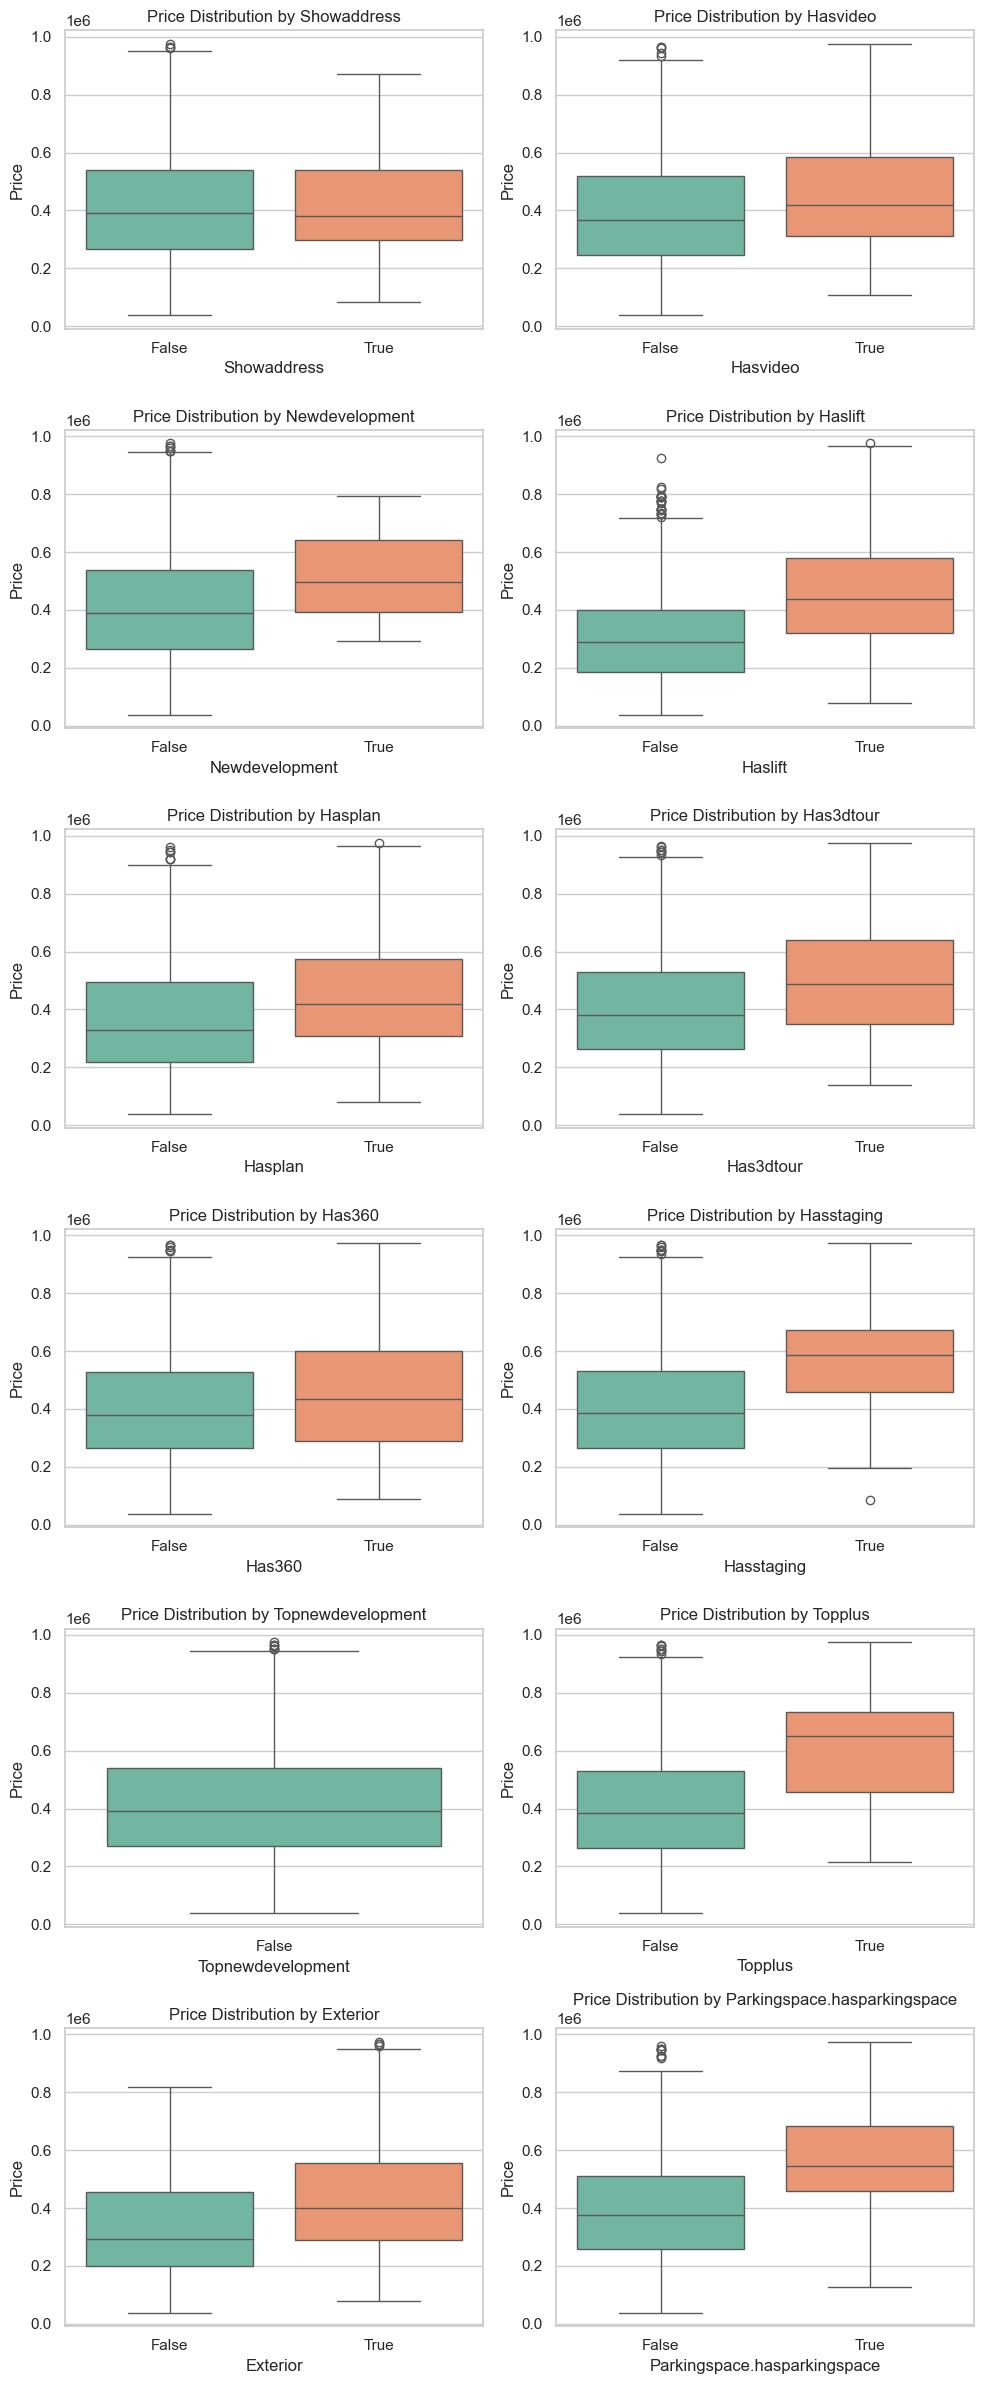

In [54]:
# plot Boolean variables in boxplots
amenity_columns = ['hasLift', 'hasVideo', 'has3DTour', 'has360', 'hasStaging', 'has3DTour',
         'hasPlan', 'newDevelopment', 'topPlus', 'exterior', 'parkingSpace.hasParkingSpace'
        ]
        
for col in amenity_columns:
    bcn_df[col] = bcn_df[col].fillna(False).astype(bool)
        
eda_methods = EdaMethods(bcn_df)

eda_methods.plot_boolean_boxplots('price')

In [55]:
results = []

# Loop through each boolean column
for col in amenity_columns:
    count_0 = (bcn_df[col] == 0).sum()  # Count of 0s
    count_1 = (bcn_df[col] == 1).sum()  # Count of 1s
    avg_price_0 = bcn_df[bcn_df[col] == 0]['price'].mean()  # Average price for 0
    avg_price_1 = bcn_df[bcn_df[col] == 1]['price'].mean()  # Average price for 1
    difference = avg_price_1 - avg_price_0  # Difference between the two averages
    
    # Calculate percentage difference for prices
    if avg_price_0 != 0:
        percentage_diff_price = (difference / avg_price_0)   # Percentage difference in price
    else:
        percentage_diff_price = None  # If avg_price_0 is 0, set percentage difference to None

    # Calculate percentage difference for counts with respect to 1
    if count_1 != 0:
        percentage_true_count = (count_1 / (count_0 + count_1))   # Percentage of True values
    else:
        percentage_true_count = None  # If count_1 is 0, set percentage difference to None
    
    # Append the results to the list
    results.append({
        'Feature': col,
        '% True': percentage_true_count,
        'Increase in Price True vs False (%)': percentage_diff_price
    })

# Convert the list of results to a DataFrame
results_df = pd.DataFrame(results)

# Sort the results by the percentage of True values in descending order
results_df = results_df.sort_values(by='% True', ascending=False)

# Display the sorted DataFrame
results_df


,Feature,% True,Increase in Price True vs False (%)
9,exterior,0.818596,0.250382
0,hasLift,0.695088,0.424740
6,hasPlan,0.601754,0.194535
1,hasVideo,0.410175,0.142616
3,has360,0.182807,0.107796
10,parkingSpace.hasParkingSpace,0.095789,0.421551
2,has3DTour,0.065965,0.212014
5,has3DTour,0.065965,0.212014
4,hasStaging,0.028070,0.361143
8,topPlus,0.023860,0.469037


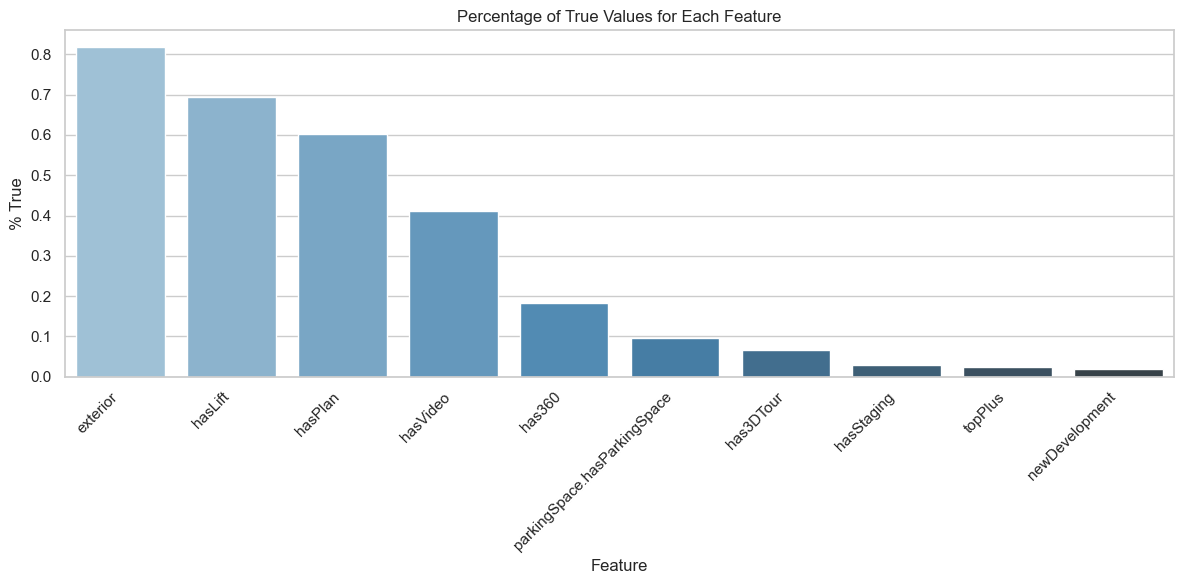

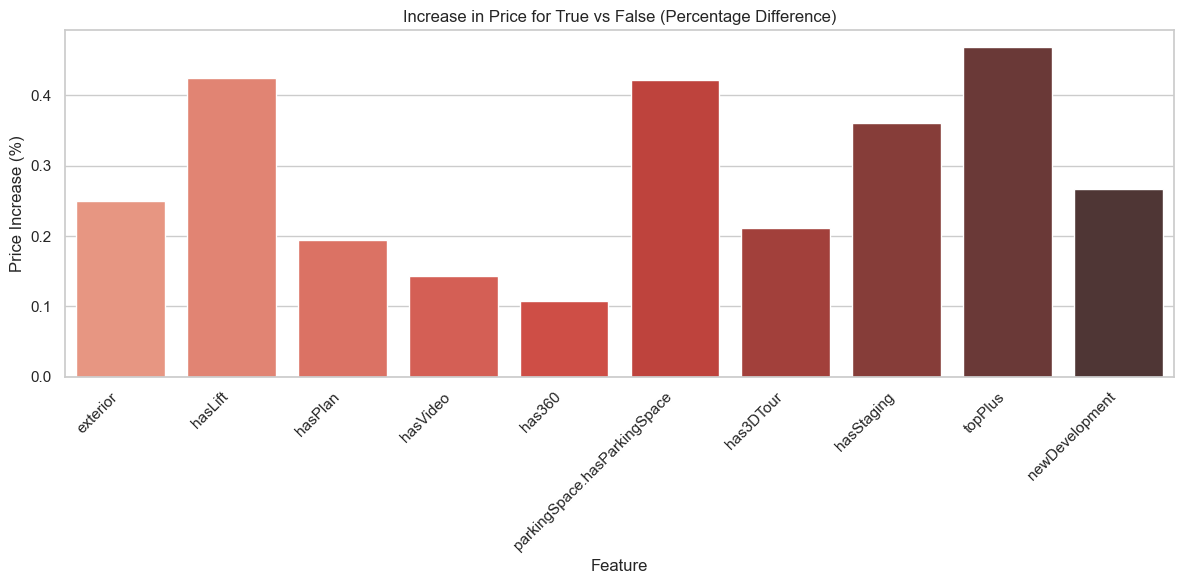

In [56]:
# Set up the plotting style
sns.set(style="whitegrid")

# Plotting the percentage of True values
plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='% True', data=results_df, palette='Blues_d')
plt.title('Percentage of True Values for Each Feature')
plt.xlabel('Feature')
plt.ylabel('% True')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

# Plotting the increase in price for True vs False (percentage difference)
plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='Increase in Price True vs False (%)', data=results_df, palette='Reds_d')
plt.title('Increase in Price for True vs False (Percentage Difference)')
plt.xlabel('Feature')
plt.ylabel('Price Increase (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()


In [57]:
# transformation
for col in amenity_columns:
    bcn_df[col] = bcn_df[col].fillna(False).astype(int)

bcn_df[amenity_columns].dtypes

hasLift                         int64
hasVideo                        int64
has3DTour                       int64
has360                          int64
hasStaging                      int64
has3DTour                       int64
hasPlan                         int64
newDevelopment                  int64
topPlus                         int64
exterior                        int64
parkingSpace.hasParkingSpace    int64
dtype: object

In [58]:
bcn_df[amenity_columns] 

,hasLift,hasVideo,has3DTour,has360,hasStaging,has3DTour,hasPlan,newDevelopment,topPlus,exterior,parkingSpace.hasParkingSpace
0,1,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,1,1,0,1,1,0
2,1,0,0,0,0,0,1,0,1,1,0
3,0,1,1,0,0,1,1,0,0,0,0
4,1,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2917,0,1,0,0,0,0,1,0,0,1,0
2918,1,1,0,1,0,0,1,0,0,1,0
2919,1,1,0,0,0,0,0,0,0,1,1
2920,1,1,0,0,0,0,0,0,0,1,0


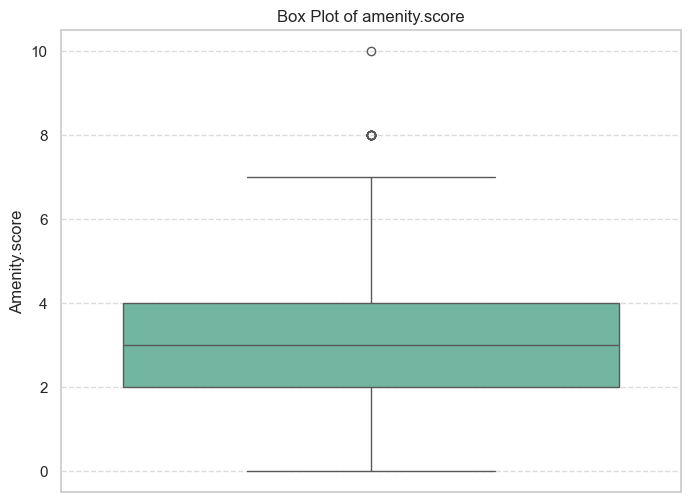

In [59]:
# Create the 'amenity.score' column as the sum of all amenity or content in the listing columns
bcn_df['amenity.score'] = bcn_df[amenity_columns].sum(axis=1)

eda_methods = EdaMethods(bcn_df)

# Step 3: Plot the boxplot of the 'amenity.score' column
eda_methods.plot_boxplot('amenity.score')

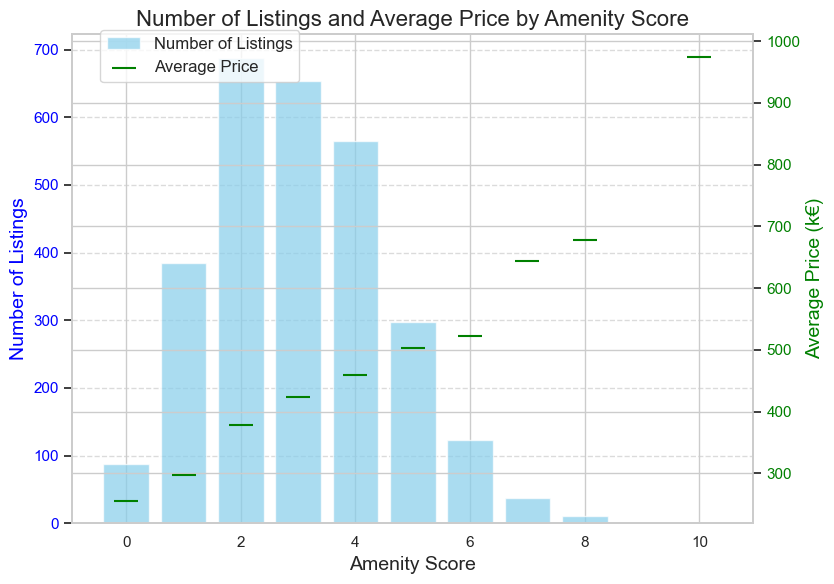

In [60]:
# Group data by 'amenity.score' and calculate the count and mean price
grouped_data = bcn_df.groupby('amenity.score').agg(
    count=('price', 'size'),
    avg_price=('price', 'mean')
).reset_index()

# Convert avg_price to thousands (k)
grouped_data['avg_price_k'] = grouped_data['avg_price'] / 1000

# Create the figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the count of rows as bars
ax1.bar(grouped_data['amenity.score'], grouped_data['count'], color='skyblue', label='Number of Listings', alpha=0.7)
ax1.set_xlabel('Amenity Score', fontsize=14)
ax1.set_ylabel('Number of Listings', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Number of Listings and Average Price by Amenity Score', fontsize=16)

# Create the second axis for average price in thousands (k)
ax2 = ax1.twinx()
ax2.scatter(
    grouped_data['amenity.score'], grouped_data['avg_price_k'],
    color='green', marker='_', s=300, label='Average Price'
)
ax2.set_ylabel('Average Price (k€)', fontsize=14, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add a grid
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Combine legends on the left
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
all_handles = handles1 + handles2
all_labels = labels1 + labels2

fig.legend(all_handles, all_labels, loc='upper left', bbox_to_anchor=(0.1, 0.95), fontsize=12)

# Adjust layout and show plot
fig.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space for legend
plt.show()


When more amenities a listing contains, higher is the price.
The biggest amount of listing have 2 to 4 amenities.

## Correlation

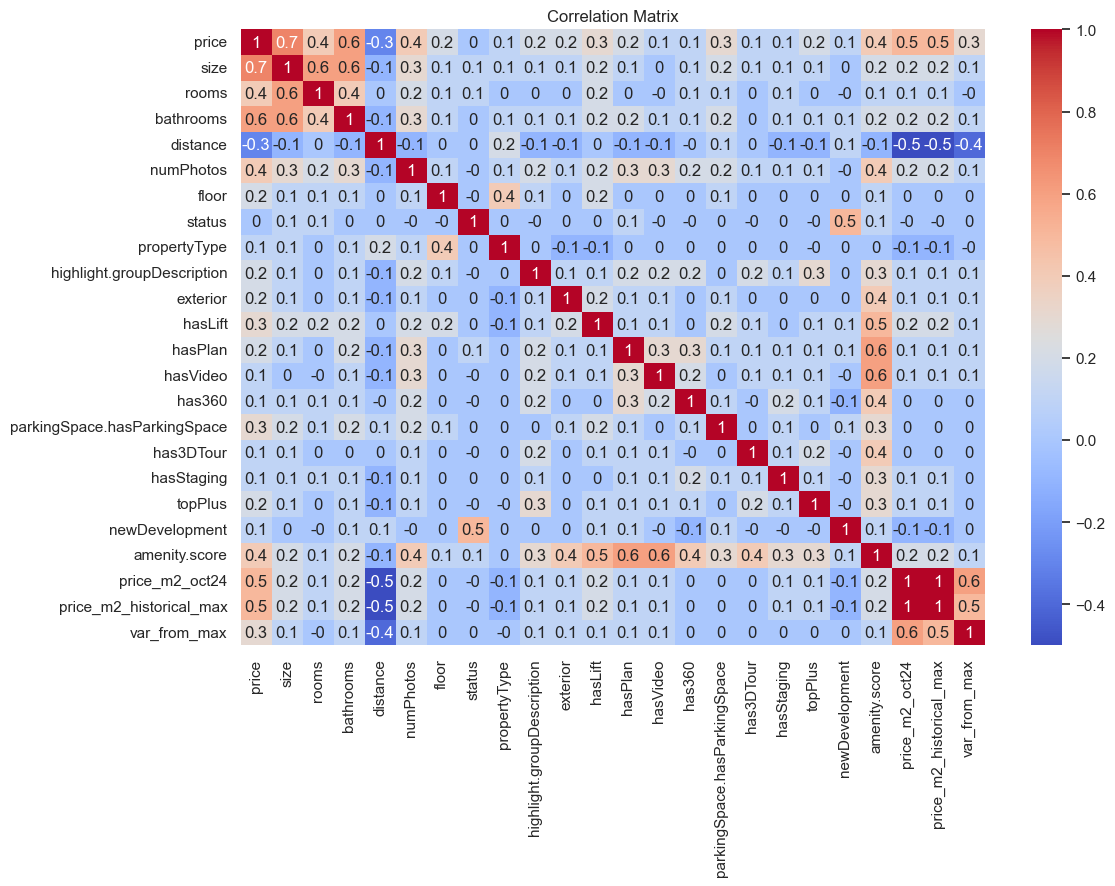

In [63]:
# corr matrix
eda_methods = EdaMethods(bcn_df)
eda_methods.plot_correlation_heatmap(['price', 'size', 'rooms', 'bathrooms', 'distance', 'numPhotos','floor', 'status', 'propertyType', 'highlight.groupDescription', 'exterior', 
                                      'hasLift', 'hasPlan', 'hasVideo', 'has360', 'parkingSpace.hasParkingSpace', 'has3DTour', 'hasStaging', 'topPlus', 'newDevelopment',
                                      'amenity.score' ,'price_m2_oct24', 'price_m2_historical_max', 'var_from_max'])

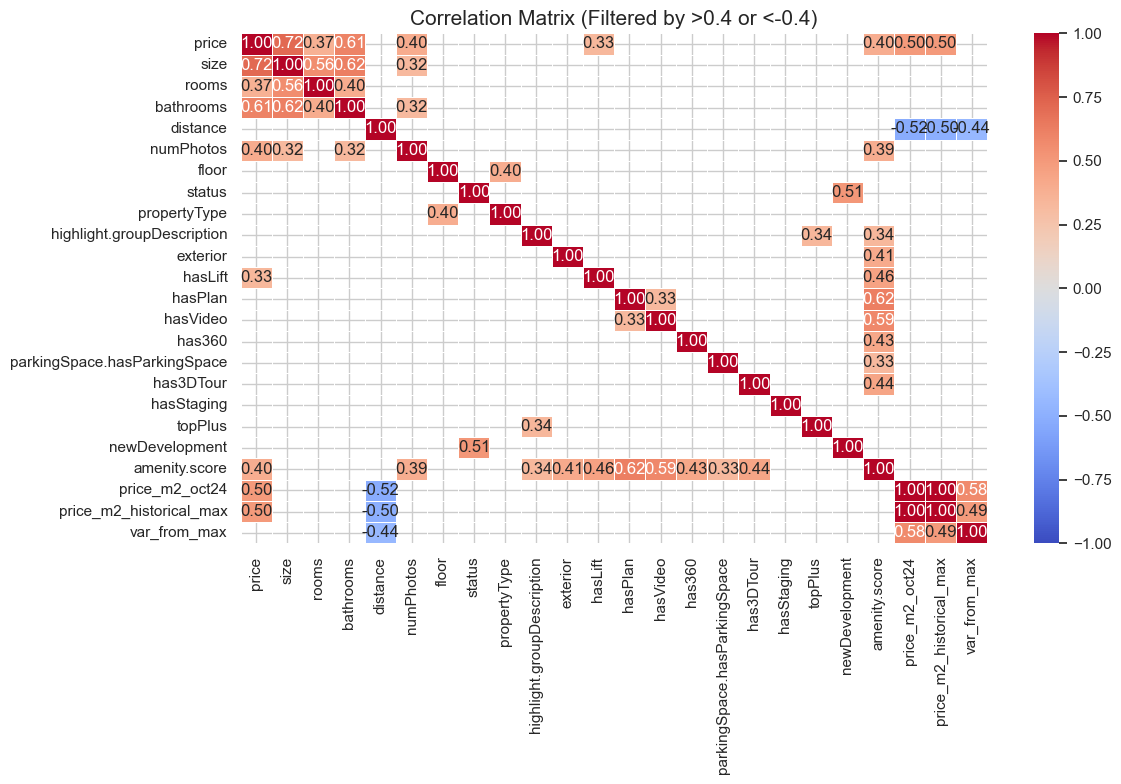

In [64]:
# List of selected columns
columns_to_include = ['price', 'size', 'rooms', 'bathrooms', 'distance', 'numPhotos', 'floor', 'status', 'propertyType', 
                      'highlight.groupDescription', 'exterior', 'hasLift', 'hasPlan', 'hasVideo', 'has360', 
                      'parkingSpace.hasParkingSpace', 'has3DTour', 'hasStaging', 'topPlus', 'newDevelopment', 
                      'amenity.score', 'price_m2_oct24', 'price_m2_historical_max', 'var_from_max']

# Compute the correlation matrix
corr_matrix = bcn_df[columns_to_include].corr()

# Filter correlations to keep only those greater than 0.4 or less than -0.4
filtered_corr_matrix = corr_matrix[(corr_matrix > 0.3) | (corr_matrix < -0.3)]

# Plot the filtered correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

# Set the title and display the plot
plt.title('Correlation Matrix (Filtered by >0.4 or <-0.4)', fontsize=15)
plt.tight_layout()
plt.show()

In [65]:
# check coolineality for linear models

eda_methods.plot_vif(['size', 'rooms', 'bathrooms', 'distance', 'numPhotos', 'floor', 'status', 'propertyType', 
                      'highlight.groupDescription', 'exterior', 'hasLift', 'hasPlan', 'hasVideo', 'has360', 
                      'parkingSpace.hasParkingSpace', 'has3DTour', 'hasStaging', 'topPlus', 'newDevelopment', 
                      'amenity.score', 'price_m2_oct24', 'price_m2_historical_max', 'var_from_max'])

Variance Inflation Factor (VIF):
                        Variable           VIF
0                           size  1.955850e+01
1                          rooms  1.143713e+01
2                      bathrooms  1.270083e+01
3                       distance  5.419259e+00
4                      numPhotos  7.945816e+00
5                          floor  2.566875e+00
6                         status  1.236938e+01
7                   propertyType  1.078520e+01
8     highlight.groupDescription  3.333837e+00
9                       exterior           inf
10                       hasLift           inf
11                       hasPlan           inf
12                      hasVideo           inf
13                        has360           inf
14  parkingSpace.hasParkingSpace           inf
15                     has3DTour           inf
16                    hasStaging           inf
17                       topPlus           inf
18                newDevelopment           inf
19                 amenity.

In [66]:
eda_methods.plot_vif(['size', 'distance', 'numPhotos', 'floor', 'status', 'propertyType', 
                      'highlight.groupDescription',
                      'amenity.score',  'var_from_max'])

Variance Inflation Factor (VIF):
                     Variable       VIF
0                        size  9.430961
1                    distance  4.283461
2                   numPhotos  7.398964
3                       floor  2.418929
4                      status  6.954457
5                propertyType  9.254507
6  highlight.groupDescription  2.945873
7               amenity.score  6.321644
8                var_from_max  1.390784


In [67]:
eda_methods.plot_vif(['size',   'price_m2_oct24',])

Variance Inflation Factor (VIF):
         Variable       VIF
0            size  8.554012
1  price_m2_oct24  8.554012


As mentioned, the correlation matrix confirm the correlation between some variables and the target variable price, but also the correlation between predictor variables, that will need adressed. The VIF means that these variables might be highly correlated with each other, and this could lead to problems in interpreting the regression model. Combining variables, that will be done in the transformation part is one possibility to solve this problem.

### Drop columns

In [68]:
# Double check missing values again
columns_to_drop = [
            "_id", "propertyCode", "thumbnail", "externalReference", "operation", 
            "address", "country", "latitude", "longitude", 
            "url", "description", "priceInfo.price.amount", "priceInfo.price.currencySuffix", 
            "suggestedTexts.subtitle", "suggestedTexts.title", "priceInfo.price.priceDropInfo.formerPrice",
            'priceInfo.price.priceDropInfo.priceDropValue',  'topNewDevelopment', 'municipality', 'province',  'newDevelopmentFinished', 'detailedType.typology', 'detailedType.subTypology', 'priceInfo.price.priceDropInfo.priceDropPercentage',
               'parkingSpace.isParkingSpaceIncludedInPrice', 'parkingSpace.parkingSpacePrice', 'showAddress'
        ]
bcn_df = bcn_df.drop(columns=columns_to_drop, errors='ignore')

missing_data = bcn_df.isnull().sum()
print("Missing values:\n", missing_data[missing_data > 0])

# Even though this fields still have missing data, since we are not going to use them as predictor variables we will not delete them
# Furtheremore it can be usefull for showing them in the final dashboard

Missing values:
 Series([], dtype: int64)


### New features

In [69]:
# # Creating new variables

bcn_df['rooms+bathrooms'] = bcn_df['rooms'] + bcn_df['bathrooms']
bcn_df['room.to.size.ratio'] = bcn_df['rooms']/bcn_df['size']
bcn_df['room+bathrooms.to.size.ratio'] = bcn_df['rooms+bathrooms'] / bcn_df['size']
bcn_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2850 entries, 0 to 2921
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   numPhotos                     2850 non-null   int64  
 1   price                         2850 non-null   int64  
 2   propertyType                  2850 non-null   int64  
 3   size                          2850 non-null   float64
 4   rooms                         2850 non-null   int64  
 5   bathrooms                     2850 non-null   int64  
 6   district                      2850 non-null   object 
 7   neighborhood                  2850 non-null   object 
 8   distance                      2850 non-null   int64  
 9   hasVideo                      2850 non-null   int64  
 10  status                        2850 non-null   int64  
 11  newDevelopment                2850 non-null   int64  
 12  hasLift                       2850 non-null   int64  
 13  priceByA

In [70]:
### One hot encoding

In [71]:
bcn_df[[ 'district', 'neighborhood'] ].value_counts()

district        neighborhood                          
Ciutat Vella    El Raval                                  188
                El Gòtic                                  157
                Sant Pere - Santa Caterina i la Ribera    157
Eixample        L'Antiga Esquerra de l'Eixample           127
                La Dreta de l'Eixample                    118
                                                         ... 
Sants-Montjuïc  La Marina del Prat Vermell                  5
Sant Martí      Sant Martí de Provençals                    3
Horta Guinardó  La Vall d'Hebron - La Clota                 2
Nou Barris      Canyelles                                   1
Sant Andreu     Baró de Viver                               1
Name: count, Length: 68, dtype: int64

In [72]:
# Columns to apply one-hot encoding to
columns_to_encode = [ 'district', 'neighborhood'] 

# Apply one-hot encoding to these columns
bcn_df = pd.get_dummies(bcn_df, columns=columns_to_encode, drop_first=True)
bcn_df = bcn_df.astype({col: 'int' for col in bcn_df.select_dtypes('bool').columns})
bcn_df.head()

,numPhotos,price,propertyType,size,rooms,bathrooms,distance,hasVideo,status,newDevelopment,...,neighborhood_Sant Martí de Provençals,neighborhood_Sant Pere - Santa Caterina i la Ribera,neighborhood_Sants,neighborhood_Sants - Badal,neighborhood_Sarrià,neighborhood_Vallcarca i els Penitents,neighborhood_Vallvidrera - El Tibidabo i les Planes,neighborhood_Verdun,neighborhood_Vila de Gràcia,neighborhood_Vilapicina i la Torre Llobeta
0,22,249000,1,55.0,2,1,3905,0,1,0,...,False,False,False,False,False,False,False,False,False,False
1,40,749000,1,118.0,2,2,3472,1,1,0,...,False,False,False,False,False,False,False,False,False,False
2,39,330000,1,69.0,2,1,2888,0,1,0,...,False,False,False,False,False,False,False,False,True,False
3,32,749000,1,118.0,2,2,3578,1,1,0,...,False,False,False,False,False,False,False,False,False,False
4,26,479000,1,105.0,4,1,2237,0,1,0,...,False,False,False,False,False,False,False,False,False,False


Only a few outliers have been removed since there is already an specified range for properties prices.